## Time Series Analysis On EarthQauke Data

In [47]:
#import statements
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import geopandas as gpd
import datetime as dt
import datetime as dt
#sklearn imports
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [4]:
#import dataframe
df = pd.read_csv(r"C:\Everything On This PC\Udacity\Git_hseju\turkey-chapter-predicting-earthquakes\src\data/Omdena_Turkey__final_rev1.csv", index_col=0)

#display first five rows
df.head()


Latitude  Longitude  Depth(km)   xM   MD   ML   Mw   Ms   Mb  Type  \
0      37.8       29.1        5.0  5.0  5.0  0.0  NaN  0.0  0.0     1   
1      37.8       29.1       20.0  4.9  4.8  4.8  4.9  4.8  4.9     1   
2      37.8       28.7       30.0  5.5  5.2  5.2  5.5  5.3  5.2     1   
3      37.5       29.0       15.0  4.5  4.5  0.0  NaN  0.0  0.0     1   
4      37.5       29.0       15.0  5.3  5.0  4.9  5.3  5.0  5.0     1   

                                            Location     City     AREA_  \
0             DENIZLI (DENIZLI) [North East  2.3 km]  DENIZLI  4621.875   
1             DENIZLI (DENIZLI) [North East  2.3 km]  DENIZLI  4621.875   
2  HACIHIDIRLAR-KARACASU (AYDIN) [North East  2.9...    AYDIN  2866.059   
3         MEDET-TAVAS (DENIZLI) [South West  1.7 km]  DENIZLI  4621.875   
4         MEDET-TAVAS (DENIZLI) [South West  1.7 km]  DENIZLI  4621.875   

            geometry                Date_Time  Year  Month  Hour  
0  POINT (29.1 37.8)  1900-09-20 00:00:01.000  1900      9     0  
1  POINT (29.1 37.8)  1904-01-01 11:38:00.000  1904      1    11  
2  POINT (28.7 37.8)  1910-08-07 21:45:00.000  1910      8    21  
3    POINT (29 37.5)  1920-07-02 14:13:01.000  1920      7    14  
4    POINT (29 37.5)  1920-07-04 12:17:58.000  1920      7    12

In [6]:
df.dtypes

Latitude     float64
Longitude    float64
Depth(km)    float64
xM           float64
MD           float64
ML           float64
Mw           float64
Ms           float64
Mb           float64
Type           int64
Location      object
City          object
AREA_        float64
geometry      object
Date_Time     object
Year           int64
Month          int64
Hour           int64
dtype: object

Let's convert the date time datatype to datetime

In [38]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

Let us try to see the magnitude with timeline for different magnitude values.

In [62]:
df_sorted = df.sort_values('Date_Time', ascending=True)


<AxesSubplot:xlabel='Date_Time'>

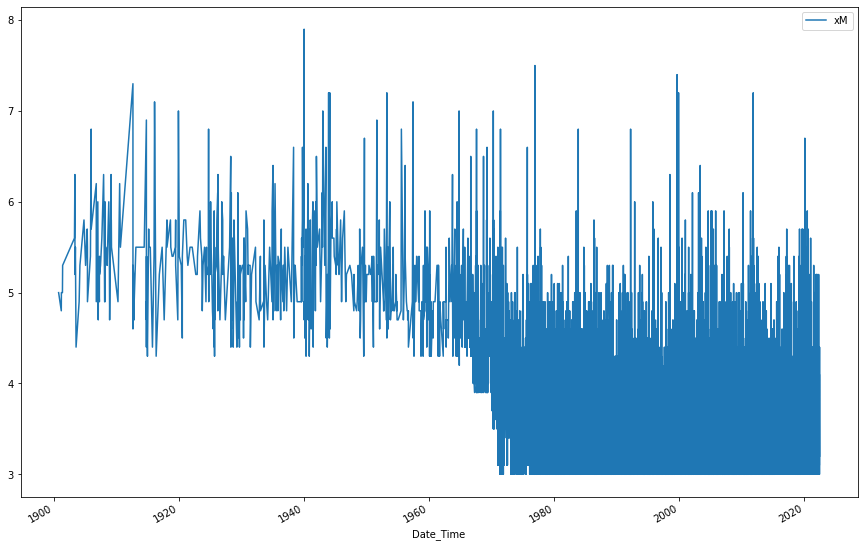

In [56]:
df_sorted.plot(x='Date_Time', y='xM', figsize=(15,10))


We can create a separate column that will have a the float value of magnitude to categorize it and use it as color scale in plotting later. 


In [66]:
df_sorted['mag_hue'] = np.floor((df_sorted['xM']))
df_sorted['mag_hue']

0        5.0
2686     4.0
3154     5.0
5162     5.0
2687     5.0
        ... 
40240    3.0
40241    3.0
30840    3.0
38740    4.0
8041     3.0
Name: mag_hue, Length: 43432, dtype: float64

let's try to get all entries for year 2000 to get more clear view.

In [57]:
df_2000 = df_sorted[df_sorted['Date_Time'].dt.year ==2000]

<AxesSubplot:xlabel='Date_Time'>

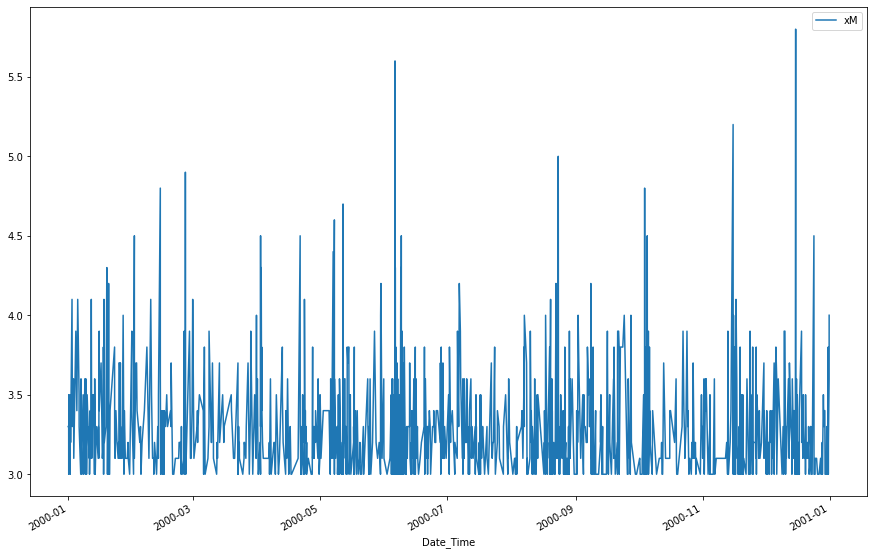

In [58]:
df_2000.plot(x='Date_Time', y='xM', figsize=(15,10))

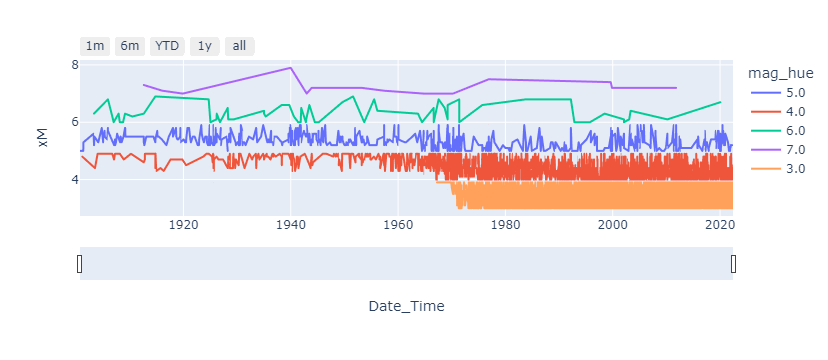

In [68]:
fig = px.line(df_sorted, x=df_sorted.Date_Time, y="xM", range_x=['2005-07-01','2010-12-31'], color='mag_hue')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

We can somewhat get an idea of the earthquake pattern here that every 10-12 year we get a very devastating earthquake with magnitude more or near to 7 and that can be visualized from 1970 to current year. 

In the 20th century, mostly higher magnitude earthquakes have been recorded and it is after 70's that we started to have more data on seismic activity in Turkey. 

It is very interesting to note that there were earthquakes of higher magnitude quite frequent in years from 1900 to 1976 and then the frequency of earthquakes greater than magnitude of 6 have been decreased. This is easily visible from the peaks. 

Some idea around the different magnitudes and its effect.
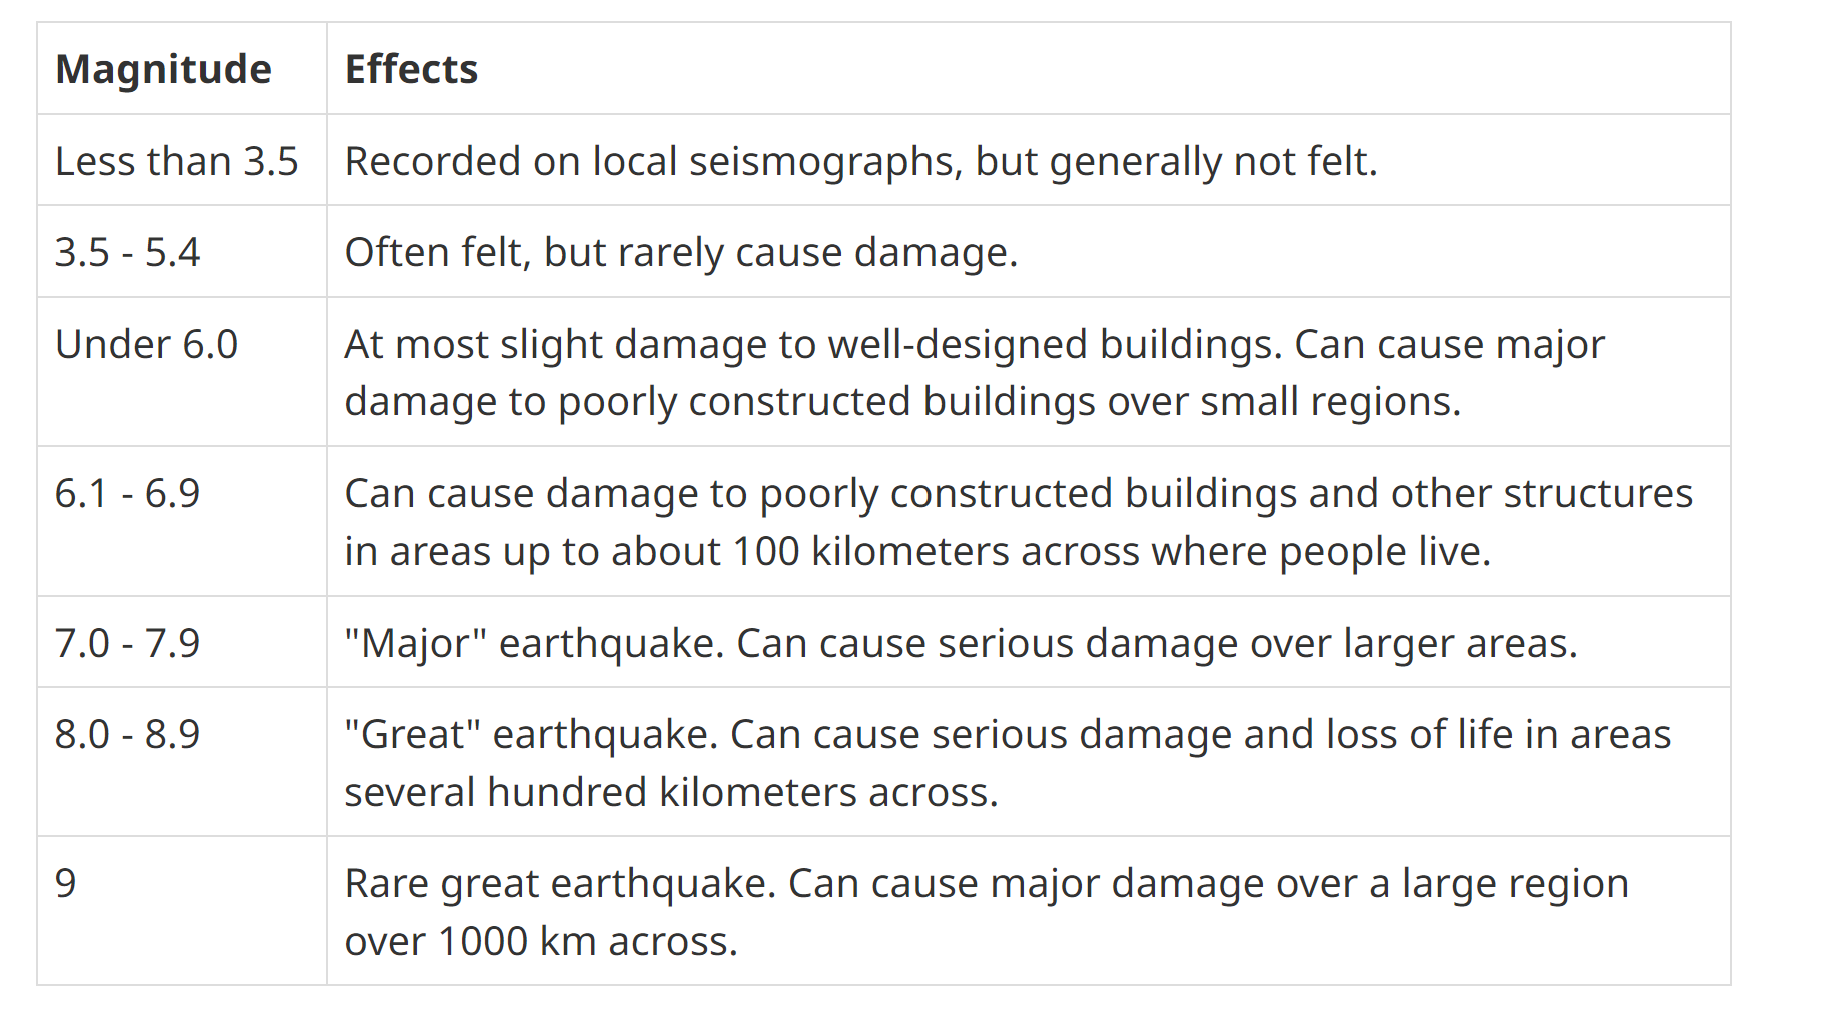

Taken from : https://earthquakescanada.nrcan.gc.ca/info-gen/scales-echelles/magnitude-en.php

We can try to see if we have data point measured for the same location for different time.


In [72]:
df_sorted.duplicated().value_counts()


False    43432
dtype: int64

So we do no thave the same location for the earthquake that occured over a period of time interval. We could not have exact coordinates but at least nearby coordinates.


In [75]:
#get the data only for one city Denizli

df_DENIZLI = df_sorted[df_sorted['City']=='DENIZLI']
df_DENIZLI.head()

Latitude  Longitude  Depth(km)   xM   MD   ML   Mw   Ms   Mb  Type  \
0      37.8       29.1        5.0  5.0  5.0  0.0  NaN  0.0  0.0     1   
1      37.8       29.1       20.0  4.9  4.8  4.8  4.9  4.8  4.9     1   
3      37.5       29.0       15.0  4.5  4.5  0.0  NaN  0.0  0.0     1   
4      37.5       29.0       15.0  5.3  5.0  4.9  5.3  5.0  5.0     1   
5      37.5       29.0       15.0  5.4  5.1  5.1  5.4  5.2  5.1     1   

                                     Location     City     AREA_  \
0      DENIZLI (DENIZLI) [North East  2.3 km]  DENIZLI  4621.875   
1      DENIZLI (DENIZLI) [North East  2.3 km]  DENIZLI  4621.875   
3  MEDET-TAVAS (DENIZLI) [South West  1.7 km]  DENIZLI  4621.875   
4  MEDET-TAVAS (DENIZLI) [South West  1.7 km]  DENIZLI  4621.875   
5  MEDET-TAVAS (DENIZLI) [South West  1.7 km]  DENIZLI  4621.875   

            geometry           Date_Time  Year  Month  Hour  mag_hue  
0  POINT (29.1 37.8) 1900-09-20 00:00:01  1900      9     0      5.0  
1  POINT (29.1 37.8) 1904-01-01 11:38:00  1904      1    11      4.0  
3    POINT (29 37.5) 1920-07-02 14:13:01  1920      7    14      4.0  
4    POINT (29 37.5) 1920-07-04 12:17:58  1920      7    12      5.0  
5    POINT (29 37.5) 1920-07-04 20:45:40  1920      7    20      5.0

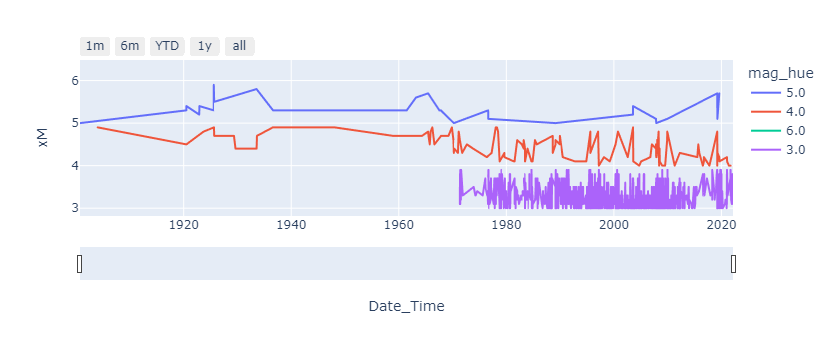

In [92]:
fig = px.line(df_DENIZLI, x=df_DENIZLI.Date_Time, y="xM", color='mag_hue')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

We see a change in spikes before a major earthqauke happens as a trend from the above time series plot. The frequency of 3 and 4 magintude earthquakes which are relatively less dangerous can reveal a potential large earthquake occurring. Different color lines above show different magnitudes of earthqukes rounded to its significant ones place. The above plot is earthquakes for only DENIZLI city in Turkey. 


## Spread of Earthquakes based on location and magnitudes in DENIZLI

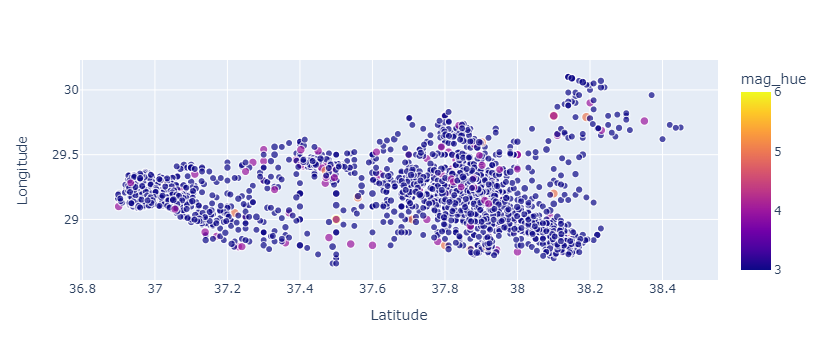

In [93]:
fig = px.scatter(df_DENIZLI, x="Latitude", y="Longitude",
	         size="xM", color="mag_hue",
                 hover_name="xM", log_x=True, size_max=10)
fig.show()